# Imports

In [1]:
from numpy import arcsin, arctan2, pi

import scipy.integrate as sci

from Model_Vehicle import *
from Trajectory_LaneChange import referenceTrajectory

# Parameters

In [2]:
class Parameters(object):
    pass

# Physical parameter
para     = Parameters()  # instance of class Parameters
para.l   = 2.850         # define car length [m]
para.lr = 1.268 / (1.620 + 1.268) * 2.850  # real length [m]
para.lf = 1.620 / (1.620 + 1.268) * 2.850  # front length [m]
para.w   = para.l * 0.3  # define car width [m]
para.ref_l = 0.0           # define dist to reference point in vehicle (from rear)
para.l_R = 0.5 * para.l   # distance center of gravity to rear wheel
para.k = 10  # [1/s] tuning for cross tracking error 1...20 seems reasonable, DARPA 2.5?
para.ksoft = 1.0  # [m/s] to avoid problems as low speeds close or equal to zero
para.dt = 1.0 / 25.0  # controller step size [s]
para.maxDelta = 25 * pi / 180  # [rad]

# two "tuning parameters" (second one is not a real tuning parameter...)
para.t_LA  = 6            # [s]
para.EG    = 4            # (m/L)*(L_r*c_r-L_f*c_f)/(c_r*c_f)
                          # Eigensteeringgradient (0...balanced, EG<0 oversteering, EG>0 understeering)

para.dt  = 0.04          # controller step size [s]
para.maxDelta = 25 * pi / 180 # [rad]

# Simulation parameter
sim_para = Parameters()  # instance of class Parameters
sim_para.t0 = 0.0          # start time
sim_para.tf = 5.0          # final time
sim_para.dt = para.dt    # step-size


# Simulation parameters

In [3]:
# initial state ##################################################################
sim_para.x0 = [0, 0, 0]
sim_para.xc0 = [0,0] # controller states
# TODO: tune Velocity
para.vx = 100 / 3.6  # vehicle speed

r_traj = referenceTrajectory(para, sim_para)

# Stanley Functions

In [4]:
def controlStanley(e, xc, p, t):
    """Function of the control law
    Args:
        e: error vector
        xc: state vector of controller (discrete states from last iteration)
        t: time
    Returns:
        u: control vector
        xc: updated state vector controller
    """
    e_fa, theta_e = e  # decompose error

    # set velocity
    vx = p.vx

    # simple stanley control
    steering_angle = theta_e + arctan2(p.k * e_fa, vx + p.ksoft)

    # normalize and limit
    steering_angle = arcsin(sin(steering_angle))
    steering_angle = np.minimum(np.maximum(steering_angle, -p.maxDelta), p.maxDelta)

    # turn rate
    turn_rate = vx / p.l * tan( steering_angle )

    return np.array([vx, steering_angle, turn_rate]).T, xc

In [5]:
def controlErrorEGOFront(ego_state, r, t, p):
    # calaculate the error with respect to the front

    x, y, theta = ego_state  # extract state vector from ego_state
    ego_pos = np.array([(x + p.l * cos(theta)), (y + p.l * sin(theta))])  # ego position vector

    target_pos, target_psi = getTargetPoint(ego_pos, r_traj)  # extract target position and orientation

    # POSITION ERROR
    error_vect = ego_pos - target_pos  # vector VA from target to ego
    traj_vect = np.array([cos(target_psi), sin(target_psi)])  # vector VB from target along road
    crossProd_z = error_vect[0] * traj_vect[1] - error_vect[1] * traj_vect[0]  # z of cross VA x VB
    e_fa = np.linalg.norm(target_pos - ego_pos)  # distance error (absolute)
    if crossProd_z < 0:  # check if left or right
        e_fa = -e_fa  # vehicle is left of trajectory

    # ORIENTATION ERROR
    theta_e = target_psi - theta  # orientation error

    return np.array([e_fa, theta_e]).T

In [6]:
def getTargetPoint(x, r):
    # calculate a target point on a polygon r (either a vertex or on a line),
    # that is closest to x

    path_size = np.size(r, 0)

    if path_size == 0:  # polygon is empty --> take x itself
        next_target_position = x[0:2]
        next_target_orientation = x[2]
        return next_target_position, next_target_orientation

    if path_size == 1:  # polygon is size 1 --> take the lonley point
        next_target_position = r[0, 0:2]
        next_target_orientation = r[0, 2]
        return next_target_position, next_target_orientation

    minDist = np.inf  # initial value to find the minimum distance
    P = x[0:2]  # extract position from vehicle

    for i in np.arange(path_size - 1):  # for each segment in the reference polygon r

        A = r[i, 0:2]  # start point of segment
        psi_A = r[i, 2]  # orientation of segment start point
        B = r[i + 1, 0:2]  # end point of segment
        psi_B = r[i + 1, 2]  # orientation of segement end point

        AB = B - A  # segment vector
        d_AB = np.linalg.norm(AB)  # length of segment
        n_AB = 1.0 / d_AB * AB  # segment vector normalized
        t_AB = np.dot((P - A), n_AB)  # dot product of vector from A to P and normalized A to B
        #     = distance of AP projected on AB in direction of AB
        if t_AB >= 0:  # distance is positive --> projection points in direction of segment
            if t_AB <= d_AB:
                next_target_position_Test = A + n_AB * t_AB
                next_target_orientation_Test = psi_A * (1.0 - t_AB / d_AB) + psi_B * t_AB / d_AB
            else:  # projection point is outside of segement AB, closer to B
                next_target_position_Test = B  # therefore the closest target point is A
                next_target_orientation_Test = psi_B
        else:  # projection point is outside of segment AB, closer to A
            next_target_position_Test = A  # therefore the closest target point is A
            next_target_orientation_Test = psi_A

        distance = np.linalg.norm(next_target_position_Test - P)  # calculate distance to closest point on segment

        if i == 0:  # initial case (1st distance is taken)
            minDist = distance
            next_target_position = next_target_position_Test
            next_target_orientation = next_target_orientation_Test

        if distance < minDist:  # check if the distance of the actual segment is less than the smallest known
            minDist = distance
            next_target_position = next_target_position_Test
            next_target_orientation = next_target_orientation_Test

    return next_target_position, next_target_orientation

# Simulation MB

In [7]:
from test_vehicle import func_MB, x0_MB
from vehiclemodels.parameters_vehicle2 import parameters_vehicle2
from scipy.integrate import odeint

tt = np.arange(sim_para.t0, sim_para.tf + sim_para.dt, sim_para.dt)  # time vector

acc = 0
v_delta = 0.0
u = [v_delta, acc]
p = parameters_vehicle2()
p.vx = para.vx

# init dynamics (to ensure shapes are compatible)
dynamics_init = odeint(func_MB, x0_MB, tt, args=(u, p))

# init shapes for plotting and simulation
x_traj = np.zeros([len(tt), len(dynamics_init[0, :])])
x_traj[0, :] = dynamics_init[0, :]
x_traj[0][3] = para.vx #velocity x
u_traj = np.zeros([len(tt), 2])
xc = [0, 0]  # controller states
e_traj = np.zeros([len(tt), 2])  # init state trace
xc = sim_para.xc0
para.p = p

for t_i in np.arange(len(tt) - 1):  # loop over time instances

    #TODO: check if 0 1 4 indizes apply to every model
    # error model
    e_traj[t_i] = controlErrorEGOFront(x_traj[t_i, [0, 1, 4]], r_traj, tt[t_i], para)
    # control law
    control, xc = controlStanley(e_traj[t_i], xc, para, tt[t_i])  # get control
    u_traj[t_i] = control[:2]
    para.steering_angle = control[1]
    para.vel = control[0]
    para.turn_rate = control[2]
    # vehicle motion with MB model
    sol = sci.solve_ivp(lambda t, x: odeCustom(x, tt, para, Model.MB),
                        (tt[t_i], tt[t_i + 1]), x_traj[t_i, :],
                        method='RK45', t_eval=tt[t_i + 1:t_i + 2])
    x_traj[t_i + 1, :] = sol.y.T  # size = len(x) x len(tt) (.T -> transpose)

# Plots

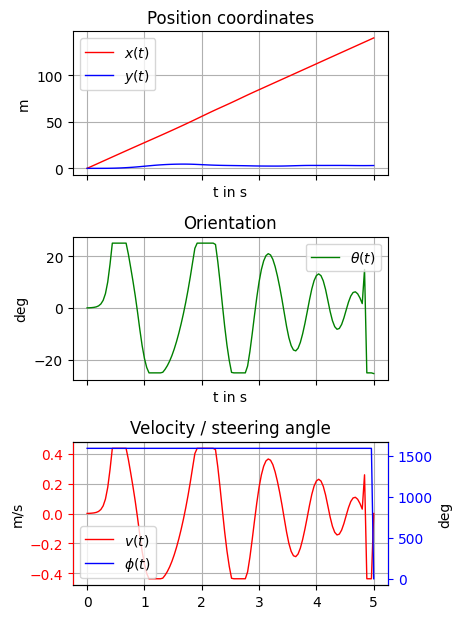

In [8]:
plt.rcParams['figure.dpi'] = 100
plot_data(x_traj, u_traj, r_traj, tt, 12, 16, 'state_trajectory_MB', save=False)

# Animation (Stanley)

In [9]:
plt.rcParams['figure.dpi'] = 100
ani = car_animation(x_traj[:, [0, 1, 4]], u_traj, r_traj, tt, para, x_traj, 'state_trajectory_MB')
plt.close()
ani

# Simulation KS

In [10]:
from test_vehicle import func_KS, x0_KS
from vehiclemodels.parameters_vehicle2 import parameters_vehicle2
from scipy.integrate import odeint

tt = np.arange(sim_para.t0, sim_para.tf + sim_para.dt, sim_para.dt)  # time vector

# init parameters
v_delta = 0.0
acc = 0
u = [v_delta, acc]
p = parameters_vehicle2()
p.vx = para.vx
# init dynamics (to ensure shapes are compatible)
dynamics_init = odeint(func_KS, x0_KS, tt, args=(u, p))

# init shapes for plotting and simulation
x_traj = np.zeros([len(tt), len(dynamics_init[0, :])])
x_traj[0, :] = dynamics_init[0, :]
x_traj[0][3] = para.vx #velocity x
u_traj = np.zeros([len(tt), 2])
xc = [0, 0]  # controller states
e_traj = np.zeros([len(tt), 2])  # init state trace
xc = sim_para.xc0
para.p = p

for t_i in np.arange(len(tt) - 1):  # loop over time instances

    # error model
    e_traj[t_i] = controlErrorEGOFront(x_traj[t_i, [0, 1, 4]], r_traj, tt[t_i], para)
    # control law
    control, xc = controlStanley(e_traj[t_i], xc, para, tt[t_i])  # get control
    u_traj[t_i] = control[:2]
    para.steering_angle = control[1]
    para.vel = control[0]
    para.turn_rate = control[2]

    # vehicle motion with KS model
    sol = sci.solve_ivp(lambda t, x: odeCustom(x, tt, para, Model.KS),
                        (tt[t_i], tt[t_i + 1]), x_traj[t_i, :],
                        method='RK45', t_eval=tt[t_i + 1:t_i + 2])
    x_traj[t_i + 1, :] = sol.y.T  # size = len(x) x len(tt) (.T -> transpose)

## Plots

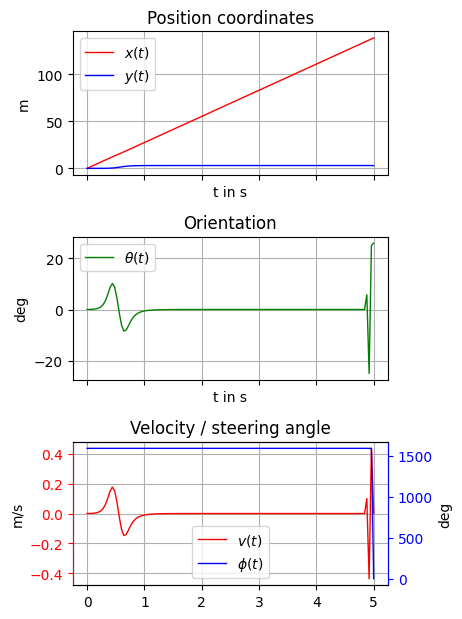

In [11]:
plt.rcParams['figure.dpi'] = 100
plot_data(x_traj, u_traj, r_traj, tt, 12, 16, 'state_trajectory_KS', save=False)

## Animation

In [12]:
plt.rcParams['figure.dpi'] = 100
ani = car_animation(x_traj[:, [0, 1, 4]], u_traj, r_traj, tt, para, x_traj, 'state_trajectory_KS')
plt.close()
ani

# Simulation ST

In [13]:
from test_vehicle import func_KS, x0_KS, func_ST, x0_ST
from vehiclemodels.parameters_vehicle2 import parameters_vehicle2
from scipy.integrate import odeint

tt = np.arange(sim_para.t0, sim_para.tf + sim_para.dt, sim_para.dt)  # time vector

v_delta = 0.0
acc = 0
u = [v_delta, acc]
p = parameters_vehicle2()
p.vx = para.vx

# init dynamics (to ensure shapes are compatible)
dynamics_init = odeint(func_ST, x0_ST, tt, args=(u, p))

# init shapes for plotting and simulation
x_traj = np.zeros([len(tt), len(dynamics_init[0, :])])
x_traj[0, :] = dynamics_init[0, :]
x_traj[0][3] = para.vx #velocity x
u_traj = np.zeros([len(tt), 2])
xc = [0, 0]  # controller states
e_traj = np.zeros([len(tt), 2])  # init state trace
xc = sim_para.xc0
para.p = p

for t_i in np.arange(len(tt) - 1):  # loop over time instances

    # error model
    e_traj[t_i] = controlErrorEGOFront(x_traj[t_i, [0, 1, 4]], r_traj, tt[t_i], para)
    # control law
    control, xc = controlStanley(e_traj[t_i], xc, para, tt[t_i])  # get control
    u_traj[t_i] = control[:2]
    para.steering_angle = control[1]
    para.vel = control[0]
    para.turn_rate = control[2]
    # vehicle motion with ST
    sol = sci.solve_ivp(lambda t, x: odeCustom(x, tt, para, Model.ST),
                        (tt[t_i], tt[t_i + 1]), x_traj[t_i, :],
                        method='RK45', t_eval=tt[t_i + 1:t_i + 2])
    x_traj[t_i + 1, :] = sol.y.T  # size = len(x) x len(tt) (.T -> transpose)

## Plot

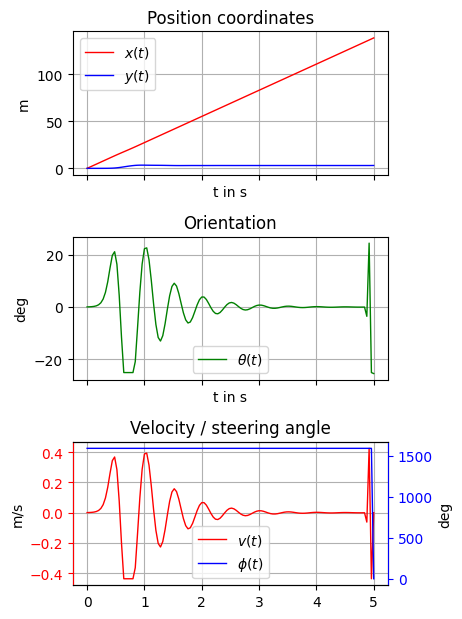

In [14]:
plt.rcParams['figure.dpi'] = 100
plot_data(x_traj, u_traj, r_traj, tt, 12, 16, 'state_trajectory_ST', save=False)

## Animation

In [15]:
plt.rcParams['figure.dpi'] = 100
ani = car_animation(x_traj[:, [0, 1, 4]], u_traj, r_traj, tt, para, x_traj, 'state_trajectory_ST')
plt.close()
ani

# Simulation STD

In [16]:
from test_vehicle import func_KS, x0_KS, func_STD, x0_STD
from vehiclemodels.parameters_vehicle2 import parameters_vehicle2
from scipy.integrate import odeint

tt = np.arange(sim_para.t0, sim_para.tf + sim_para.dt, sim_para.dt)  # time vector

v_delta = 0.0
acc = 0
u = [v_delta, acc]
p = parameters_vehicle2()
p.vx = para.vx

# init dynamics (to ensure shapes are compatible)
dynamics_init = odeint(func_STD, x0_STD, tt, args=(u, p))

# init shapes for plotting and simulation
x_traj = np.zeros([len(tt), len(dynamics_init[0, :])])
x_traj[0, :] = dynamics_init[0, :]
x_traj[0][3] = para.vx #velocity x
u_traj = np.zeros([len(tt), 2])
xc = [0, 0]  # controller states
e_traj = np.zeros([len(tt), 2])  # init state trace
xc = sim_para.xc0
para.p = p

for t_i in np.arange(len(tt) - 1):  # loop over time instances

    # error model
    e_traj[t_i] = controlErrorEGOFront(x_traj[t_i, [0, 1, 4]], r_traj, tt[t_i], para)
    # control law
    control, xc = controlStanley(e_traj[t_i], xc, para, tt[t_i])  # get control
    u_traj[t_i] = control[:2]
    para.steering_angle = control[1]
    para.vel = control[0]
    para.turn_rate = control[2]

    # vehicle motion for model STD
    sol = sci.solve_ivp(lambda t, x: odeCustom(x, tt, para, Model.STD),
                        (tt[t_i], tt[t_i + 1]), x_traj[t_i, :],
                        method='RK45', t_eval=tt[t_i + 1:t_i + 2])
    x_traj[t_i + 1, :] = sol.y.T  # size = len(x) x len(tt) (.T -> transpose)

## Plot

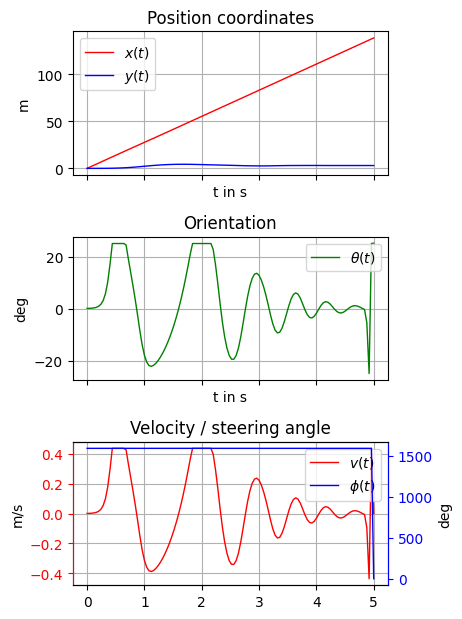

In [17]:
plt.rcParams['figure.dpi'] = 100
plot_data(x_traj, u_traj, r_traj, tt, 12, 16, 'state_trajectory_STD', save=False)

## Animation

In [18]:
plt.rcParams['figure.dpi'] = 100
ani = car_animation(x_traj[:, [0, 1, 4]], u_traj, r_traj, tt, para, x_traj, 'state_trajectory_STD')
plt.close()
ani